# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Comparing random forest, XGBoost, MLP and LSTM

<br></font>
</div>

# Imoprt modules

In [1]:
import numpy as np
import pandas as pd
import copy
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import callbacks

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 16

# Import dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- There are 9 days.
- Each day has 24 hrs. The observation has registered every hour.
- The total number of instances is: 9*24 = 216 points.

<br></font>
</div>

In [2]:
ads_col = 'Ads'
time_col = 'Time'
input_path = "../../DATASETS/ads.csv"
ads = pd.read_csv(input_path, index_col=time_col, parse_dates=[time_col])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


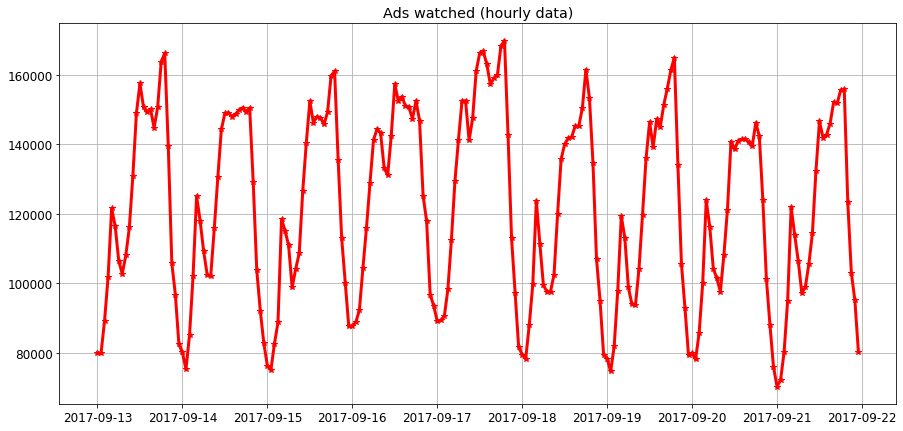

In [3]:
rcParams['font.size'] = 12
#register_matplotlib_converters()
plt.figure(figsize = (15, 7))
plt.plot(ads[ads_col], "r*-", lw = 3)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

# Features engineering

<div class="alert alert-block alert-info">
<font color=black><br>

- Generating lagged features and window statistics from them.
- We will also add date & time features such as hour of the day, day of the week and a boolean feature indicating whether this is a weekend.
- **Window statistics**: mean of the lagged features we've created.

<br></font>
</div>

In [4]:
label_col = 'y'
data = pd.DataFrame(ads[ads_col].copy())
data.columns = [label_col]

# Add the lag of the target variable from 6 steps back up to 24
# 24 means 25 hours thus one day
for i in range(1, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)
    
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
# 5 and 6 means Saturday and Sunday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)

data = data.dropna()
data.head(10)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,102080.0,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0
2017-09-14 05:00:00,118030,125135.0,102080.0,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,...,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,5,3,0
2017-09-14 06:00:00,109225,118030.0,125135.0,102080.0,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,...,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,6,3,0
2017-09-14 07:00:00,102475,109225.0,118030.0,125135.0,102080.0,85105.0,75335.0,80125.0,82520.0,96780.0,...,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,7,3,0
2017-09-14 08:00:00,102240,102475.0,109225.0,118030.0,125135.0,102080.0,85105.0,75335.0,80125.0,82520.0,...,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,8,3,0


In [5]:
data.shape

(192, 28)

In [6]:
dataAll = copy.deepcopy(data)

In [7]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()

dimension:  (192, 28)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,123368.333333
2017-09-14 01:00:00,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,123368.750000
2017-09-14 02:00:00,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,123179.166667
2017-09-14 03:00:00,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,123003.333333
2017-09-14 04:00:00,102080.0,85105.0,75335.0,80125.0,82520.0,96780.0,105895.0,139520.0,166235.0,163840.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,123009.583333


In [8]:
pd.DataFrame(y)

,0
0,80125
1,75335
2,85105
3,102080
4,125135
...,...
187,155890
188,123395
189,103080
190,95155


# Split the data

In [9]:
def timeseries_train_test_split(X, y, test_size = 0.3):
    """Perform train-test split for time series.
    
    Data are not reshuffled and given a point in time
    the series is simply split from there. All the point
    before that point in time are used as training test,
    whereas all pint after that point in time are used
    as test set.
    """
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

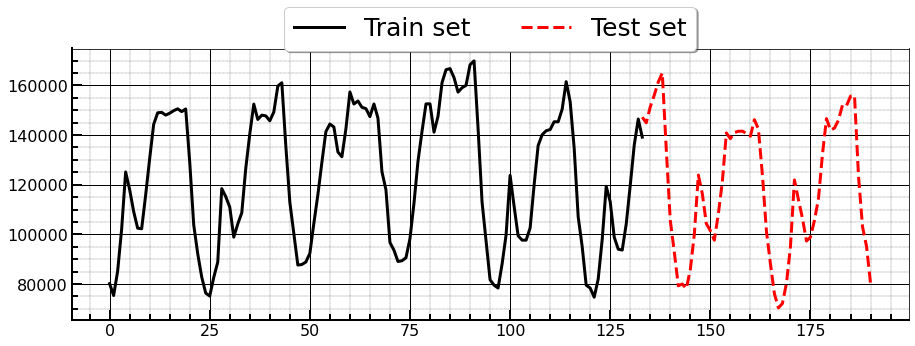

In [11]:
rcParams['font.size'] = 16

x_train = range(y_train.size)
# Adding a shift
x_test = [i + max(x_train) for i in range(y_test.size)]

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(x_train, y_train, "k-", lw = 3, label = 'Train set')
plt.plot(x_test, y_test, "r--", lw = 3, label = 'Test set')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.2),
          ncol = 2, fontsize = 25, fancybox=True, shadow=True)
ax.grid(True)

# Model

<div class="alert alert-block alert-info">
<font color=black><br>

- We are not optimising the model at this points.
- We'll try three different models:
    - Random forest
    - XGBoost
    - LSTM
    
<br></font>
</div>

## Random forest

In [12]:
model = RandomForestRegressor(max_depth = 6, n_estimators = 25)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
predictionTrain = model.predict(X_train)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
error = mean_absolute_percentage_error(prediction, y_test)
errorTrain = mean_absolute_percentage_error(predictionTrain, y_train)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(error))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrain))

Mean absolute percentage [TEST] error 4.65%
Mean absolute percentage [TRAIN] error 2.07%


**Learning curves**

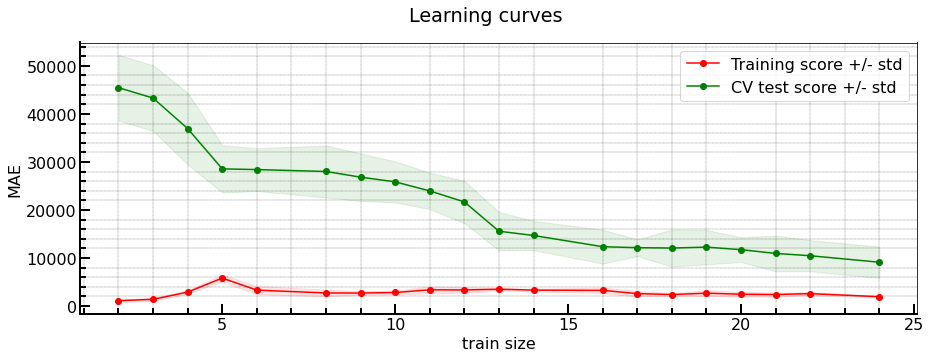

In [15]:
timeseries_cv = TimeSeriesSplit(n_splits = 5)

train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        X_train, 
                                                        y_train, 
                                                        cv = timeseries_cv, 
                                                        n_jobs = -1,
                                                        train_sizes = np.linspace(0.1, 1, 20),
                                                        scoring="neg_mean_absolute_error")        

train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = -1*np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(test_scores, axis=1)
test_scores_std = -1*np.std(test_scores, axis=1)


# Plot learning curve
fig = plt.figure() 
fig.suptitle("Learning curves") 
ax = fig.add_subplot(111) 

ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score +/- std")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV test score +/- std")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("train size")
ax.set_ylabel("MAE")

plt.legend(loc = "best")
plt.grid()

## XGBoost

In [16]:
eval_set = [(X_train, y_train), (X_test, y_test)]
modelXGB = XGBRegressor(objective = 'reg:squarederror', 
                        max_depth = 6, 
                        n_estimators = 50)                                                              
a = modelXGB.fit(X_train, y_train, eval_metric = "mae", eval_set = eval_set)

resultsXGB = modelXGB.evals_result()

[0]	validation_0-mae:110769	validation_1-mae:107145
[1]	validation_0-mae:99915	validation_1-mae:96207.2
[2]	validation_0-mae:90136.1	validation_1-mae:86646.4
[3]	validation_0-mae:81354	validation_1-mae:78053.3
[4]	validation_0-mae:73424.6	validation_1-mae:70169.8
[5]	validation_0-mae:66230	validation_1-mae:63152.1
[6]	validation_0-mae:59765.4	validation_1-mae:56599.3
[7]	validation_0-mae:53946.9	validation_1-mae:50987.9
[8]	validation_0-mae:48667.4	validation_1-mae:45821.1
[9]	validation_0-mae:43917.7	validation_1-mae:41140.5
[10]	validation_0-mae:39641.1	validation_1-mae:37000.1
[11]	validation_0-mae:35799.4	validation_1-mae:33355
[12]	validation_0-mae:32310.6	validation_1-mae:29941.7
[13]	validation_0-mae:29162.5	validation_1-mae:26849.8
[14]	validation_0-mae:26328.6	validation_1-mae:24098.9
[15]	validation_0-mae:23804.7	validation_1-mae:21652.6
[16]	validation_0-mae:21526.3	validation_1-mae:19482.6
[17]	validation_0-mae:19462.4	validation_1-mae:17498.8
[18]	validation_0-mae:17594.5	

In [17]:
predictionTestXGB = modelXGB.predict(X_test)
predictionTrainXGB = modelXGB.predict(X_train)

In [18]:
errorTestXGB = mean_absolute_percentage_error(predictionTestXGB, y_test)
errorTrainXGB = mean_absolute_percentage_error(predictionTrainXGB, y_train)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestXGB))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainXGB))

Mean absolute percentage [TEST] error 3.96%
Mean absolute percentage [TRAIN] error 0.84%


**Learning curves**

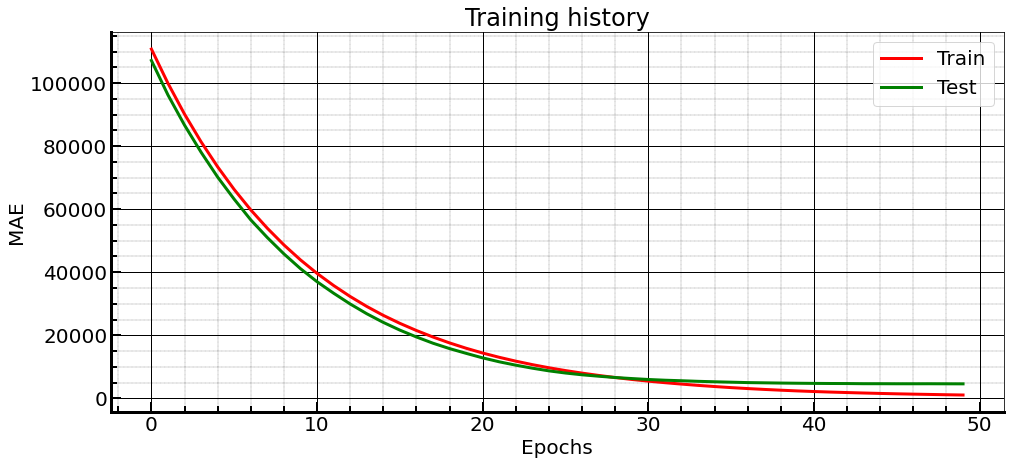

In [19]:
epochs = len(resultsXGB['validation_0']["mae"]) 
x_axis = range(0, epochs)

rcParams['figure.figsize'] = 16, 7
rcParams['font.size'] = 20

fig, ax = plt.subplots()
ax.plot(x_axis, resultsXGB['validation_0']["mae"], 'r-', lw = 3, label = 'Train') 
ax.plot(x_axis, resultsXGB['validation_1']["mae"], 'g', lw = 3, label = 'Test') 
ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("MAE")
plt.title('Training history')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.minorticks_on()
plt.show()

## MLPs

<div class="alert alert-block alert-info">
<font color=black><br>

- ANNs are **sensitive** to the scaling of their inputs.
- So we are going to normalised the input.
- This is different from tree-based methods such as a gradietn boosting and random forest.
- Pay attention to **data leakage**. We are scaling the data after we did the splitting. If you scale the data all together some features of the test set will be used into the training and this is **bad practice**.

<br></font>
</div>

In [20]:
scaler_Xtrain = MinMaxScaler(feature_range = (0, 1))
X_train_s = scaler_Xtrain.fit_transform(X_train)
scaler_ytrain = MinMaxScaler(feature_range = (0, 1))
y_train_s = scaler_ytrain.fit_transform(y_train.reshape(-1, 1))

scaler_Xtest = MinMaxScaler(feature_range = (0, 1))
X_test_s = scaler_Xtest.fit_transform(X_test)
scaler_ytest = MinMaxScaler(feature_range = (0, 1))
y_test_s = scaler_ytest.fit_transform(y_test.reshape(-1, 1))

In [21]:
# Reshape the numpy.array for keras
print(X_train.shape, y_train.shape)
print(X_train_s.shape, y_train_s.shape)

(134, 28) (134,)
(134, 28) (134, 1)


In [22]:
print(X_test.shape, y_test.shape)
print(X_test_s.shape, y_test_s.shape)

(58, 28) (58,)
(58, 28) (58, 1)


In [23]:
early_stopping = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta=0.001, 
    # How many epochs to wait before stopping
    patience = 100, 
    restore_best_weights = True,
)

In [24]:
modelMLP_s = Sequential()
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(1))
modelMLP_s.compile(loss = "mean_squared_error", metrics = ["mae"], optimizer = "adam")
historyMLP_s = modelMLP_s.fit(X_train_s, y_train_s, 
                          validation_data = (X_test_s, y_test_s), 
                          epochs = 300, 
                          batch_size = 1, 
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/300
134/134 [==============================] - 17s 4ms/step - loss: 0.1165 - mae: 0.2501 - val_loss: 0.0407 - val_mae: 0.1645
Epoch 2/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0163 - mae: 0.1033 - val_loss: 0.0380 - val_mae: 0.1659
Epoch 3/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0151 - mae: 0.0988 - val_loss: 0.0215 - val_mae: 0.1148
Epoch 4/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0107 - mae: 0.0836 - val_loss: 0.0273 - val_mae: 0.1307
Epoch 5/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0071 - mae: 0.0646 - val_loss: 0.0290 - val_mae: 0.1361
Epoch 6/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0073 - mae: 0.0678 - val_loss: 0.0186 - val_mae: 0.1132
Epoch 7/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0083 - mae: 0.0731 - val_loss: 0.0180 - val_mae: 0.1020
Epoch 8/300
134/134 [==============================] - 0s 1ms/step -

134/134 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0076 - val_mae: 0.0654
Epoch 124/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0359 - val_loss: 0.0181 - val_mae: 0.1033
Epoch 125/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0315 - val_loss: 0.0068 - val_mae: 0.0619
Epoch 126/300
134/134 [==============================] - 0s 1ms/step - loss: 9.4053e-04 - mae: 0.0230 - val_loss: 0.0095 - val_mae: 0.0714
Epoch 127/300
134/134 [==============================] - 0s 1ms/step - loss: 8.4443e-04 - mae: 0.0212 - val_loss: 0.0089 - val_mae: 0.0713
Epoch 128/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0116 - val_mae: 0.0821
Epoch 129/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0098 - val_mae: 0.0713
Epoch 130/300
134/134 [==============================] - 0s 1

In [25]:
# Estimate model performance
predictionTestMLP_s = modelMLP_s.predict(X_test_s)
predictionTrainMLP_s = modelMLP_s.predict(X_train_s)

In [26]:
errorTestMLP_s = mean_absolute_percentage_error(predictionTestMLP_s, y_test_s)
errorTrainMLP_s = mean_absolute_percentage_error(predictionTrainMLP_s, y_train_s)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestMLP_s))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainMLP_s))

Mean absolute percentage [TEST] error 15.18%
Mean absolute percentage [TRAIN] error 11.57%


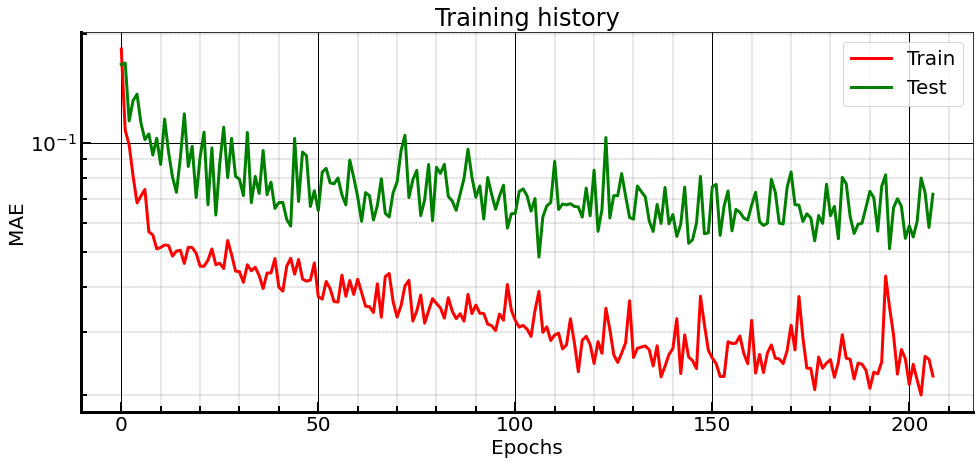

In [27]:
epochs_s = len(historyMLP_s.history[ "mae"]) 
x_axis_s = range(0, epochs_s)

rcParams['figure.figsize'] = 16, 7
rcParams['font.size'] = 20

fig, ax = plt.subplots()
ax.plot(x_axis_s, historyMLP_s.history[ "mae"], 'r-', lw = 3, label = 'Train') 
ax.plot(x_axis_s, historyMLP_s.history[ "val_mae"], 'g', lw = 3, label = 'Test') 
ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("MAE")
plt.title('Training history')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.yscale('log')
ax.minorticks_on()
plt.show()

## LSTM

<div class="alert alert-block alert-info">
<font color=black><br>

- There 6 flavours of the LSTM ANNs we can choose from:
    - Data Preparation
    - Vanilla LSTM
    - Stacked LSTM
    - Bidirectional LSTM
    - CNN LSTM
    - ConvLSTM

We'll investigate the first only.

<br></font>
</div>

In [28]:
n_steps = 23
n_features = 1

In [29]:
X_train_s.shape

(134, 28)

In [30]:
# We need to reshape it for the purpouses of LSTM
X_train_ss = X_train_s.reshape((X_train_s.shape[0], X_train_s.shape[1], n_features))
X_test_ss = X_test_s.reshape((X_test_s.shape[0], X_test_s.shape[1], n_features))

In [31]:
X_train_ss.shape

(134, 28, 1)

In [32]:
y_train_ss = y_train_s.reshape((y_train_s.shape[0], y_train_s.shape[1], n_features))
y_test_ss = y_test_s.reshape((y_test_s.shape[0], y_test_s.shape[1], n_features))
y_train_ss.shape

(134, 1, 1)

In [33]:
# Just print out the inputs to make sure they are all OK
for i in range(len(X_train_ss)):
    print(X_train_s[i], y_train_s[i])

[0.08243201 0.23217473 0.32789037 0.68098288 0.96151423 0.93636459
 0.79827785 0.73621758 0.79208233 0.78362911 0.79854038 0.87073401
 0.77967711 0.58984911 0.4325736  0.34742007 0.29191727 0.33095916
 0.43626675 0.4906616  0.28278991 0.14978369 0.05017411 0.05260103
 0.         0.5        0.         0.33457015] [0.05728237]
[0.05728237 0.08243201 0.23217473 0.32789037 0.68098288 0.96151423
 0.93636459 0.79827785 0.73621758 0.79208233 0.78362911 0.79854038
 0.87010657 0.77967711 0.58984911 0.4325736  0.34742007 0.29191727
 0.33095916 0.43626675 0.4906616  0.28278991 0.14978369 0.05017411
 0.04347826 0.5        0.         0.33459185] [0.00698309]
[0.00698309 0.05728237 0.08243201 0.23217473 0.32789037 0.68098288
 0.96151423 0.93636459 0.79827785 0.73621758 0.79208233 0.78362911
 0.79756252 0.87010657 0.77967711 0.58984911 0.4325736  0.34742007
 0.29191727 0.33095916 0.43626675 0.4906616  0.28278991 0.14978369
 0.08695652 0.5        0.         0.324719  ] [0.10957681]
[0.10957681 0.00698

In [34]:
# define model
modelLSTM = Sequential()
modelLSTM.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape = (n_steps, n_features)))
modelLSTM.add(LSTM(100, activation='relu'))
#modelLSTM.add(LSTM(100, activation = 'relu', input_shape = (n_steps, n_features)))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss = "mean_squared_error", metrics = ["mae"], optimizer = "adam")

In [35]:
early_stopping_LSTM = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta = 0.001, 
    # How many epochs to wait before stopping
    patience = 300, 
    restore_best_weights = True,
)

In [36]:
X_train_ss.shape

(134, 28, 1)

In [37]:
# Fit model
historyLSTM = modelLSTM.fit(X_train_ss, y_train_ss,
                          validation_data = (X_test_ss, y_test_ss), 
                          epochs = 300, 
                          batch_size = 1, 
                          verbose = 1,
                          callbacks = [early_stopping_LSTM])

Epoch 1/300
134/134 [==============================] - 12s 17ms/step - loss: 0.1096 - mae: 0.2685 - val_loss: 0.0618 - val_mae: 0.2152
Epoch 2/300
134/134 [==============================] - 1s 10ms/step - loss: 0.0486 - mae: 0.1845 - val_loss: 0.0275 - val_mae: 0.1338
Epoch 3/300
134/134 [==============================] - 2s 11ms/step - loss: 0.0327 - mae: 0.1488 - val_loss: 0.0252 - val_mae: 0.1278
Epoch 4/300
134/134 [==============================] - 1s 10ms/step - loss: 0.0243 - mae: 0.1323 - val_loss: 0.0273 - val_mae: 0.1296
Epoch 5/300
134/134 [==============================] - 1s 10ms/step - loss: 0.0167 - mae: 0.1017 - val_loss: 0.0206 - val_mae: 0.1140
Epoch 6/300
134/134 [==============================] - 1s 10ms/step - loss: 0.0215 - mae: 0.1213 - val_loss: 0.0216 - val_mae: 0.1195
Epoch 7/300
134/134 [==============================] - 1s 10ms/step - loss: 0.0165 - mae: 0.1026 - val_loss: 0.0192 - val_mae: 0.1080
Epoch 8/300
134/134 [==============================] - 1s 10m

134/134 [==============================] - 1s 11ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0025 - val_mae: 0.0405
Epoch 115/300
134/134 [==============================] - 2s 12ms/step - loss: 0.0029 - mae: 0.0428 - val_loss: 0.0030 - val_mae: 0.0430
Epoch 116/300
134/134 [==============================] - 2s 12ms/step - loss: 0.0015 - mae: 0.0308 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 117/300
134/134 [==============================] - 2s 12ms/step - loss: 0.0027 - mae: 0.0416 - val_loss: 0.0069 - val_mae: 0.0589
Epoch 118/300
134/134 [==============================] - 2s 13ms/step - loss: 0.0020 - mae: 0.0352 - val_loss: 0.0063 - val_mae: 0.0640
Epoch 119/300
134/134 [==============================] - 2s 13ms/step - loss: 0.0022 - mae: 0.0378 - val_loss: 0.0027 - val_mae: 0.0420
Epoch 120/300
134/134 [==============================] - 1s 11ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0029 - val_mae: 0.0441
Epoch 121/300
134/134 [==============================] - 1s 11

134/134 [==============================] - 2s 15ms/step - loss: 7.5150e-04 - mae: 0.0206 - val_loss: 0.0034 - val_mae: 0.0447
Epoch 234/300
134/134 [==============================] - 2s 16ms/step - loss: 9.3216e-04 - mae: 0.0236 - val_loss: 0.0039 - val_mae: 0.0453
Epoch 235/300
134/134 [==============================] - 2s 15ms/step - loss: 7.7477e-04 - mae: 0.0214 - val_loss: 0.0044 - val_mae: 0.0505
Epoch 236/300
134/134 [==============================] - 2s 15ms/step - loss: 5.6031e-04 - mae: 0.0190 - val_loss: 0.0056 - val_mae: 0.0591
Epoch 237/300
134/134 [==============================] - 2s 17ms/step - loss: 9.3239e-04 - mae: 0.0235 - val_loss: 0.0042 - val_mae: 0.0510
Epoch 238/300
134/134 [==============================] - 2s 17ms/step - loss: 5.2892e-04 - mae: 0.0175 - val_loss: 0.0049 - val_mae: 0.0522
Epoch 239/300
134/134 [==============================] - 2s 15ms/step - loss: 7.5236e-04 - mae: 0.0211 - val_loss: 0.0032 - val_mae: 0.0431
Epoch 240/300
134/134 [===========

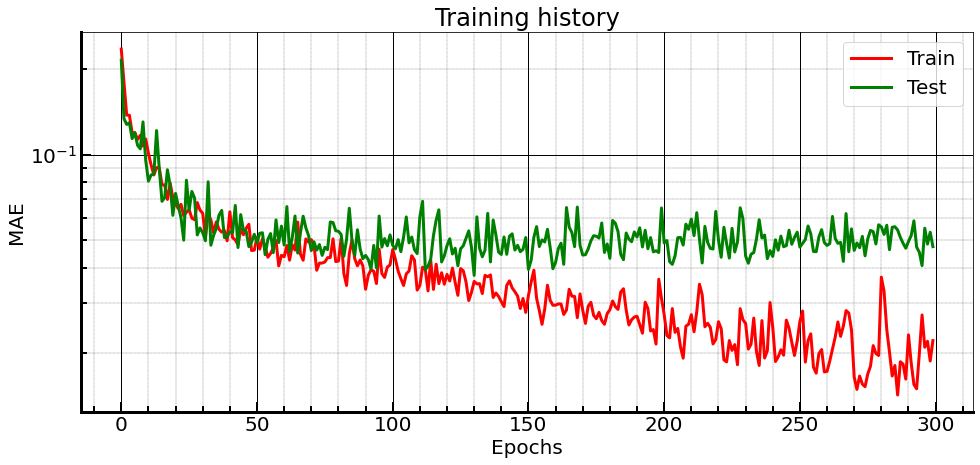

In [38]:
epochs = len(historyLSTM.history[ "mae"]) 
x_axis = range(0, epochs)

rcParams['figure.figsize'] = 16, 7
rcParams['font.size'] = 20

fig, ax = plt.subplots()
ax.plot(x_axis, historyLSTM.history[ "mae"], 'r-', lw = 3, label = 'Train') 
ax.plot(x_axis, historyLSTM.history[ "val_mae"], 'g', lw = 3, label = 'Test') 
ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("MAE")
plt.title('Training history')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.yscale('log')
ax.minorticks_on()
plt.show()

In [39]:
# Estimate model performance
predictionTestLSTM = modelLSTM.predict(X_test_ss)
predictionTrainLSTM = modelLSTM.predict(X_train_ss)

In [40]:
errorTestLSTM = mean_absolute_percentage_error(predictionTestLSTM, y_test_s)
errorTrainLSTM = mean_absolute_percentage_error(predictionTrainLSTM, y_train_s)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestLSTM))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainLSTM))

Mean absolute percentage [TEST] error 20.29%
Mean absolute percentage [TRAIN] error 7.12%


# Plotting

## Comparing train + test sets

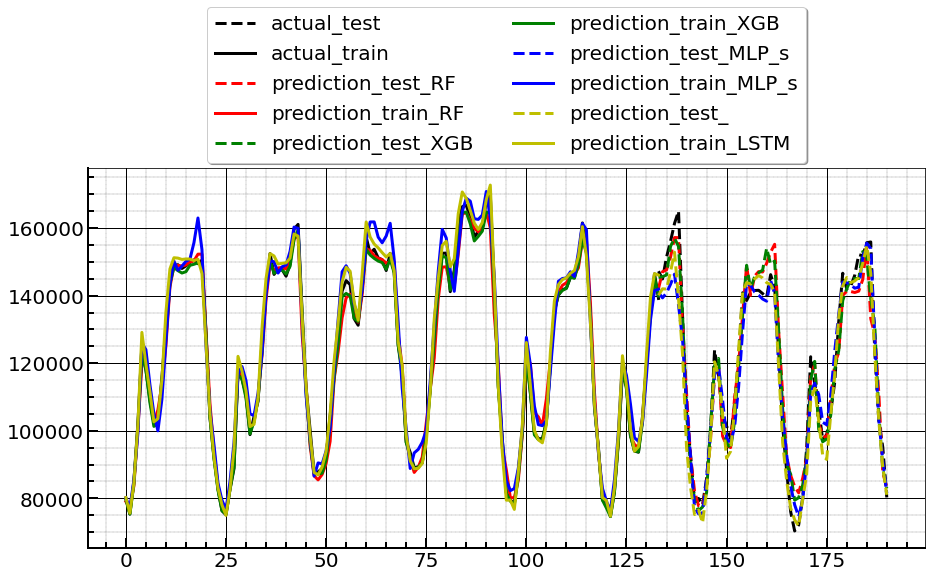

In [41]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

x_train = range(y_train.size)
x = [i + max(x_train) for i in range(prediction.size)]

# Train and test sets
plt.plot(x, y_test, "k--", lw = 3, label='actual_test')
plt.plot(x_train, y_train, "k-", lw = 3, label='actual_train')

# Random Forest results
plt.plot(x, prediction, "r--", lw = 3, label='prediction_test_RF')
plt.plot(x_train, predictionTrain, "r-", lw = 3, label='prediction_train_RF')

# XGBoost results
plt.plot(x, predictionTestXGB, "g--", lw = 3, label = 'prediction_test_XGB')
plt.plot(x_train, predictionTrainXGB, "g-", lw = 3, label = 'prediction_train_XGB')

# MLPs results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestMLP_s), "b--", lw = 3, label = 'prediction_test_MLP_s')
plt.plot(x_train, scaler_ytrain.inverse_transform(predictionTrainMLP_s), "b-", lw = 3, label = 'prediction_train_MLP_s')

# LSTM results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestLSTM), "y--", lw = 3, label = 'prediction_test_')
plt.plot(x_train, scaler_ytrain.inverse_transform(predictionTrainLSTM), "y-", lw = 3, label = 'prediction_train_LSTM')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol = 2, fancybox=True, shadow=True)

plt.grid(True)

## Comparing test set only

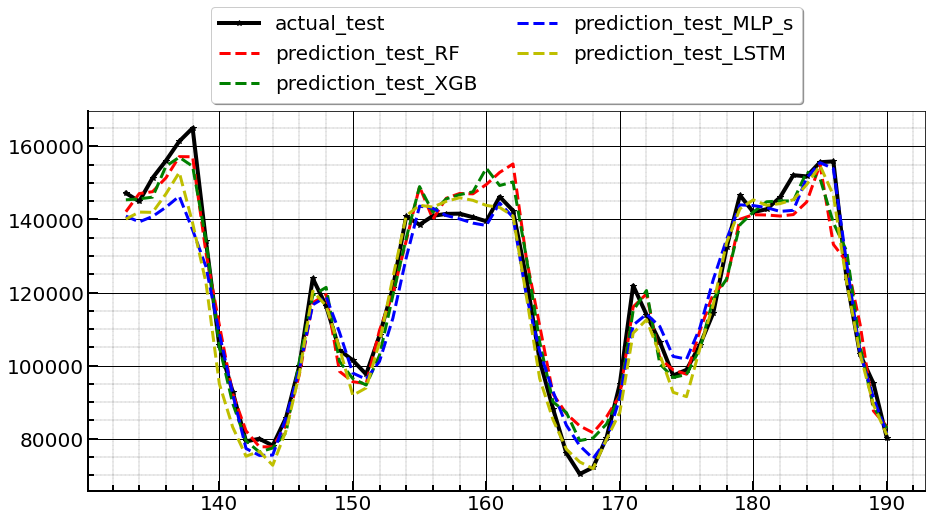

In [42]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

x_train = range(y_test.size)

# Train and test sets
plt.plot(x, y_test, "k*-", lw = 4, label='actual_test')

# Random Forest results
plt.plot(x, prediction, "r--", lw = 3, label='prediction_test_RF')

# XGBoost results
plt.plot(x, predictionTestXGB, "g--", lw = 3, label = 'prediction_test_XGB')

# MLPs results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestMLP_s), "b--", lw = 3, label = 'prediction_test_MLP_s')

# LSTM results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestLSTM), "y--", lw = 3, label = 'prediction_test_LSTM')


ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fancybox=True, shadow=True)

plt.grid(True)

# Conclusions

<div class="alert alert-block alert-danger">
<font color=black><br>

- TBA

<br></font>
</div>

# References

<div class="alert alert-block alert-warning">
<font color=black><br>

- [Blog: Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
- [Blog: How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
- [Blog: Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
- [Blog: What's wrong with my time series? Model validation without a hold-out set
](https://blog.insightdatascience.com/whats-wrong-with-my-time-series-model-validation-without-a-hold-out-set-94151d38cf5b)
- [Jupyter Notebook: Open Machine Learning Course - Time series analysis in Python](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)
- [This notebook](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/time_series/3_supervised_time_series.ipynb)

<br></font>
</div>